In [2]:
import os
import torch
import wandb
import random
import argparse
import warnings

from peft import AutoPeftModelForCausalLM
from trl import setup_chat_format, SFTTrainer
from datasets import load_dataset, disable_caching
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, TrainingArguments, pipeline

from codecarbon import EmissionsTracker

from utils import init_wandb, build_prompts, get_preds, get_labels, evaluate

warnings.filterwarnings("ignore")

In [3]:
# Free CUDA memory
torch.cuda.empty_cache()

ADAPTER_ID = "kahliahogg/climate-test"

# GPU/CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Running evaluation on {device}")

# Load test dataset
test_prompts = load_dataset("json", data_files="data/test_prompts.json", split="train")
print(f"Loaded {test_prompts.num_rows} test samples")

# Load model with PEFT adapter
model = AutoPeftModelForCausalLM.from_pretrained(
    ADAPTER_ID,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    device_map=device,
)

tokenizer = AutoTokenizer.from_pretrained(ADAPTER_ID)

# Load test dataset
test_prompts = load_dataset("json", data_files="data/test_prompts.json", split="train")
print(f"Loaded {test_prompts.num_rows} test samples")

# Load merged model into pipeline
pipe = pipeline(
    task="text-generation", 
    model=model, 
    tokenizer=tokenizer
)

Running evaluation on cuda:0
Loaded 320 test samples


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCaus

Loaded 320 test samples


100%|██████████| 320/320 [00:00<00:00, 25395.01it/s]


Test recall: 0.640625
Test precision: 0.640625
Test f1: 0.640625
Test accuracy: 0.640625


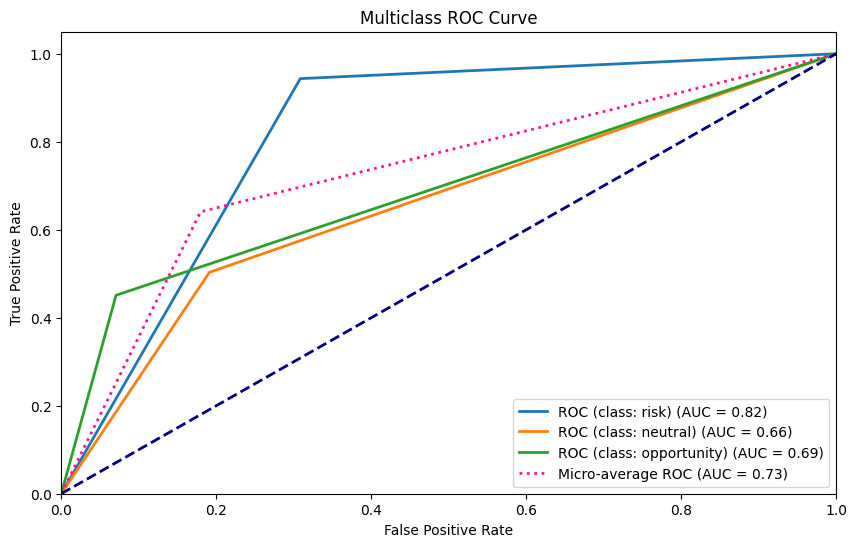

In [4]:
# Test Preds
y_preds = get_preds(test_prompts, pipe)
y_true = get_labels(test_prompts)

# Evaluate
evaluate(y_true, y_preds, ".", log_to_wandb=False)